## Using Size loss for Toy Example Segmentation

In this notebook, we will review the concepts seen about weakly-annotated segmentation using the sthe Size loss function. We utilize a toy example that will allow us to understand and visualize the behavior of the system.

**Libraries**

In [3]:
import argparse
from pathlib import Path
from typing import Any, Tuple
from operator import itemgetter
import torch
import numpy as np
import torch.nn.functional as F
from torch import nn, einsum
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

**Utilities**

In [4]:
from utils.dataset import (SliceDataset)
from utils.residual_unet import ResidualUNet
from utils.losses import (CrossEntropy,
                          PartialCrossEntropy,
                          NaiveSizeLoss)
from utils.utils import (weights_init,
                         saveImages,
                         class2one_hot,
                         probs2one_hot,
                         one_hot,
                         tqdm_,
                         dice_coef)

**Configuring GPU**

If there is an available GPU, it is going to be contained in the variable 'device', otherwise it is going to be simply the GPU.

In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 

# Toy Example

In this example, we create a toy dataset to get some intuitions of size loss and acquire the intuition behind its functionality.

**Loading the Toy dataset**

In [6]:
root_dir = 'data/TOY/'

'''Specifying the transforms for the data during training'''
transform = transforms.Compose([
                lambda img: img.convert('L'),
                lambda img: np.array(img)[np.newaxis, ...],
                lambda nd: nd /255,
                lambda nd: torch.tensor(nd, dtype=torch.float32)])

mask_transform = transforms.Compose([
                    lambda img: np.array(img)[...],
                    lambda nd: nd / 255,
                    lambda nd: torch.tensor(nd, dtype=torch.int64)[None, ...],
                    lambda t: class2one_hot(t, K=2),
                    itemgetter(0)])

In [7]:
batch_size = 1

'''Creating dataset objects to handle all our data samples'''
train_set = SliceDataset('train', root_dir, transform=transform, mask_transform=mask_transform, augment=True, equalize=False)
val_set = SliceDataset('val', root_dir, transform=transform, mask_transform=mask_transform, equalize=False)

'''Creating dataloaders, which help us iterate over the data samples'''
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=1, num_workers=4, shuffle=False)

>> Created train dataset with 10 images...
>> Created val dataset with 10 images...


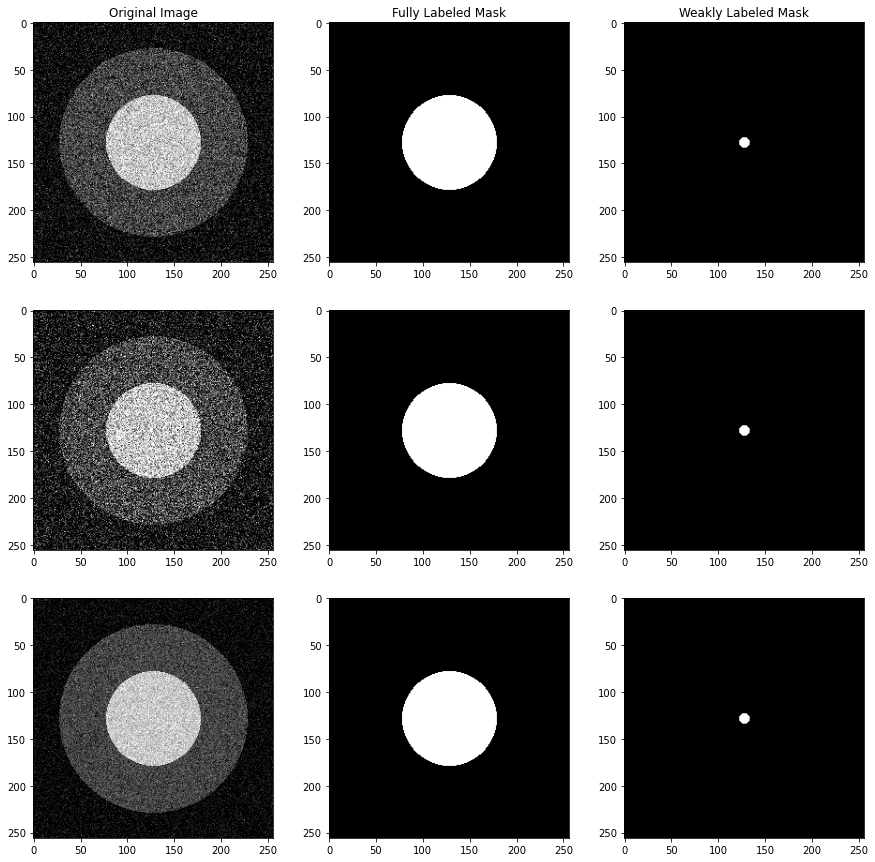

In [26]:
'''Displaying some examples'''
fig, axs = plt.subplots(3, 3)
fig.set_figheight(15)
fig.set_figwidth(15)
for i in range(3):
    data = train_set[i]
    img = data['img'] #Image
    full_mask = data['full_mask'] #Fully annotated segmentation mask
    weak_mask = data['weak_mask'] #Weakly annotated segmentation mask
    axs[i,0].imshow(img.squeeze(), cmap='gray')
    axs[i,1].imshow(full_mask[1], cmap='gray')
    axs[i,2].imshow(weak_mask[1], cmap='gray')
axs[0,0].set_title('Original Image')
axs[0,1].set_title('Fully Labeled Mask')
axs[0,2].set_title('Weakly Labeled Mask')
plt.show()

**Creating a Shallow CNN**

In [27]:
import torch.nn as nn
'''Defining a layer that contains
       |‾‾‾‾‾‾‾|     |‾‾‾‾‾‾‾‾‾‾‾‾|     |‾‾‾‾‾‾‾|
  -->  | conv  | --> |  BatchNorm | --> | PRelU | -->
       |_______|     |____________|     |_______|               '''
def convBatch(nin, nout, kernel_size=3, stride=1, padding=1, bias=False, layer=nn.Conv2d, dilation=1):
    return nn.Sequential(
        layer(nin, nout, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias, dilation=dilation),
        nn.BatchNorm2d(nout),
        nn.PReLU()
    )

'''Creating a shallow Convolutional Neural Network'''
class ShallowCNN(nn.Module):
    def __init__(self, nin, nG, nout):
        super(ShallowCNN, self).__init__()
        self.conv0 = convBatch(nin, nG * 4) #First Layer
        self.conv1 = convBatch(nG * 4, nG * 4) #Second Layer
        self.conv2 = convBatch(nG * 4, nout) #Third layer

    def forward(self, input):
        x0 = self.conv0(input)
        x1 = self.conv1(x0)
        x2 = self.conv2(x1)

        return x2

initial_kernels = 4
num_classes = 2
net = ShallowCNN(1, initial_kernels, num_classes)
net.to(device)

ShallowCNN(
  (conv0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
  )
)

**Creating loss functions**

PyTorch have several pre-defined loss functions that we can directly use. However, there might be times when we need our own loss function, e.g. size loss. Here we show how we can create any loss function from scratch. If we construct all our objects (inputs, networks, targets, etc.) as PyTorch tensors, creating and using a loss function during backpropagation is easier. To better understand how to create customize losses, please refer to the file called "losses.py".

In [28]:
ce_loss = CrossEntropy(idk=[0,1]) #To supervise both background and foreground
partial_ce = PartialCrossEntropy() #To supervise only forefround
sizeloss = NaiveSizeLoss()

Initialized CrossEntropy with {}
Initialized PartialCrossEntropy with {}
Initialized NaiveSizeLoss with {}


**Setting training configuration**

In [33]:
epochs = 150 #Number of epochs to train
lr = 0.0005 #Learning rate
optimizer = torch.optim.Adam(net.parameters(), lr=lr, betas=(0.9, 0.999)) #Optimizer
mode = 'full'
#mode = 'unconstrained'
#mode = 'constrained'

**Training phase**

In [34]:
for i in range(epochs):
    net.train()
    
    '''Tensors to save loss values'''
    log_ce = torch.zeros((len(train_loader)), device=device)
    log_sizeloss = torch.zeros((len(train_loader)), device=device)
    log_sizediff = torch.zeros((len(train_loader)), device=device)
    log_dice = torch.zeros((len(train_loader)), device=device)
    
    desc = f">> Training   ({i: 4d})"
    tq_iter = tqdm_(enumerate(train_loader), total=len(train_loader), desc=desc)
    for j, data in tq_iter:
        img = data['img'].to(device)
        full_mask = data['full_mask'].to(device)
        weak_mask = data['weak_mask'].to(device)
        bounds = data['bounds'].to(device)
        
        optimizer.zero_grad(set_to_none=True)
        
        # Sanity tests to see we loaded and encoded the data correctly
        assert 0 <= img.min() and img.max() <= 1
        B, _, W, H = img.shape
        assert B == 1  # Since we log the values in a simple way, doesn't handle more
        assert weak_mask.shape == (B, 2, W, H)
        assert one_hot(weak_mask), one_hot(weak_mask)
        
        '''Forward pass'''
        logits = net(img)
        pred_softmax = F.softmax(5*logits, dim=1)
        pred_seg = probs2one_hot(pred_softmax) #Segmentation prediction
        
        pred_size = einsum('bkwh->bk', pred_seg)[:,1]
        log_sizediff[j] = pred_size - data['true_size'][0,1]
        log_dice[j] = dice_coef(pred_seg, full_mask)[0,1]
        
        if mode == 'full':
            '''Using standard supervision with CrossEntropy Loss'''
            ce_val = ce_loss(pred_softmax, full_mask)
            log_ce[j] = ce_val.item()
            
            log_sizeloss[j] = 0
            
            lossEpoch= ce_val
        elif mode == 'unconstrained':
            ce_val = partial_ce(pred_softmax, weak_mask)
            log_ce[j] = ce_val.item()
            
            log_sizeloss[j] = 0
            
            lossEpoch = ce_val
        elif mode == 'constrained':
            '''Using sizeloss along with CrossEntropy with weak supervision'''
            ce_val = partial_ce(pred_softmax, weak_mask)
            log_ce[j] = ce_val.item()
            
            sizeLoss_val = sizeloss(pred_softmax, bounds)
            log_sizeloss[j] = sizeLoss_val.item()
            
            lossEpoch = ce_val + sizeLoss_val / 100
        
        '''Backward pass'''
        lossEpoch.backward()
        optimizer.step()
        tq_iter.set_postfix({"DSC": f"{log_dice[:j+1].mean():05.3f}",
                                 "SizeDiff": f"{log_sizediff[:j+1].mean():07.1f}",
                                 "LossCE": f"{log_ce[:j+1].mean():5.2e}",
                                 **({"LossSize": f"{log_sizeloss[:j+1].mean():5.2e}"} if mode == 'constrained' else {})})
        tq_iter.update(1)
    tq_iter.close()   
    if (i % 5) == 0:
        saveImages(net, val_loader, 1, i, 'TOY', mode, device) #Evaluate on the evaluation set and save segmented images
    

>> Training   ( 149): 100%|██████████████| 10/10 [25.54it/s, DSC=0.991, SizeDiff=00099.7, LossCE=5.20e-07, LossSize=0.00e+00]
